# COMP90051 Workshop 7
## Optimization Methods and Autoencoder

During the previous two weeks, we worked through the fundamentals of [PyTorch](https://pytorch.org/) and saw the utility of Automatic on-the-fly differentiation ([Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)) for gradient-based optimization. In this workshop we will we'll have a look at the common optimization methods in training NN and compare their differences.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sns.set_style('darkgrid')
%matplotlib inline

from sklearn.datasets import make_classification

### 1. Synthetic data set
We'll reuse the synthetic dataset from Workshop 6. Recall that it is a synthetic binary classification data set, the *degree of separability* between the two classes by adjusting the `class_sep` parameter below.
In this worksheet we deviate from the standard `0`/`1` encoding for binary class labels used in `sklearn`. 
We use `-1` in place of `0` for the "negative" class to make the mathematical presentation of the perceptron algorithm easier to digest.

**Note:** We use the `n_features` parameter to control the number of features in the synthetic data set. We stack the dummy feature `x_0 = 1` to the feature matrix `X` to account for the bias term in the linear model.

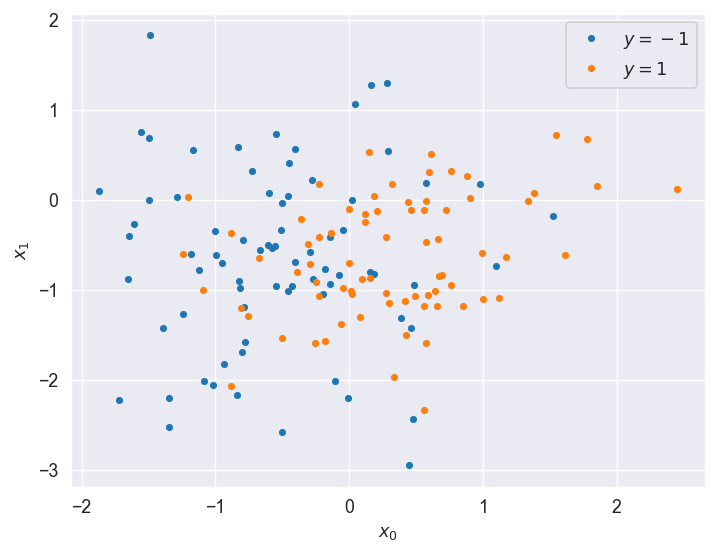

In [2]:
FIGURE_RESOLUTION = 128
plt.rcParams['figure.dpi'] = FIGURE_RESOLUTION

def create_toy_data(n_samples=150, class_sep=1.75, n_features=2):
    X, y = make_classification(n_samples=n_samples, n_features=n_features, n_informative=2, 
                               n_redundant=n_features-2, n_clusters_per_class=1, flip_y=0,
                               class_sep=class_sep, random_state=12)
    y[y==0] = -1 # encode "negative" class using -1 rather than 0
    plt.plot(X[y==-1,0], X[y==-1,1], ".", label="$y = -1$")
    plt.plot(X[y==1,0], X[y==1,1], ".", label="$y = 1$")
    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()

    return X,y

X, y = create_toy_data(n_samples=150, n_features=2, class_sep = 0.5)
X = np.hstack([np.ones((X.shape[0], 1)), X]) # add bias term

In preparation for training and evaluating a perceptron on this data, we randomly partition the data into train/test sets.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 105 instances. Test set has 45 instances.


### 2. Define the classifier

Recall from Workshop 6, we use a perceptron as the linear binary classifier which maps an input vector $\mathbf{x} \in \mathbb{R}^D$ to a binary output $y \in \{-1,1\}$ given by
$$
\begin{align*}
f(\mathbf{x}; \mathbf{w}) &= \begin{cases}
    1 & \mathrm{if} \ s(\mathbf{x}; \mathbf{w}) \geq 0, \\
    -1 & \mathrm{otherwise},
\end{cases}
\end{align*}
$$

The corresponding loss (objective) function is defined as:
$$
\begin{align*}
F(\mathbf{w}) &= \frac{1}{T} \sum_{t=1}^T \max\left(0, -y_t (\mathbf{w} \cdot \mathbf{x}_t)\right)
\end{align*}
$$

***
Exercise: Implement the functions `loss` and `gard` that compute the loss or the gradient of the loss with respect to the model parameters $\mathbf{w}$ of **a single training example**.

In [4]:
def weighted_sum(X, w):
    """
    Returns an array containing the weighted sum s(x) for each instance x in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    """
    return np.dot(X,w)

def predict(X, w):
    """
    Returns an array containing the predicted binary labels (-1/1) for each instance in the feature matrix
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    w : numpy array, shape: (n_features,)
        weights vector
    """
    return np.where(weighted_sum(X, w) >= 0, 1, -1)

def loss(x, y, w):
    """
    Returns the loss of a single example

    Arguments:
    X : numpy array, shape: (n_features,)
        feature vector
    y : int
        true label (-1 or 1)
    w : numpy array, shape: (n_features,)
        weights vector
    """
    # fill
    return max(0, - y * weighted_sum(x, w))

def gard(x, y, w):
    """
    Returns the gardient of the loss with respect to the weights

    Arguments:
    X : numpy array, shape: (n_features,)
        feature vector
    y : int
        true label (-1 or 1)
    w : numpy array, shape: (n_features,)
        weights vector
    """
    # fill
    if predict(x, w) == y:
        return np.zeros(w.shape)
    else:
        return - y * x
    

### 3. Adaptive Gradient (AdaGrad)

There are plenty of optimization algorithms available, and the choice of the optimization algorithm can have a large impact on the performance of the model.
In the previous workshops, we have seen the use of Gradient Descent (GD) and Stochastic Gradient Descent (SGD), which follows the negative gradient of the loss function to update the model parameters. A limitation of gradient descent is that it uses the **same step size** (learning rate) for each input variable. This can be a problem on objective functions that have different amounts of curvature in different dimensions, and in turn, may require a different sized step to a new point.

**Adaptive Gradients**, or **AdaGrad** for short, is an extension of the gradient descent optimization algorithm that allows the step size in each dimension used by the optimization algorithm to be automatically adapted based on the gradients seen for the variable (partial derivatives) seen over the course of the search. Specifically, frequently occurring features receive very low learning rates (and small updates) and infrequent features high learning rates (and large updates). The intuition is that the frequently feature should be rather stable while each time an infrequent feature is seen, the learner should “take notice”. Mathmatically, the parameters with the largest partial derivative of the loss have a correspondingly rapid decrease in their learning rate, while parameters with small partial derivatives have a relatively small decrease in their learning rate.

At each iteration $i$, the learner receives the gradient vector $g^{i}$. Instead of moving the model parameters in the opposite direction $-\eta g^{i}$, AdaGrad incorporates the outer product matrix $G^{i}$ that keeps records of the computed historical gradients from the beginning until the current iteration:
$$
\begin{align*}
G^{i} &= \sum_{k=1}^{i} g^{k} \cdot (g^{k})^T
\end{align*}
$$
The parameter should be updated as below according to the aforementioned intuition:
$$
\begin{align*}
\mathbf{w}^{i+1} &= \mathbf{w}^{i} - \frac{\eta}{\sqrt{(G^{i})}} \cdot g^{i}
\end{align*}
$$

However, the above algorithm is compucomputationally impractical in high dimensions since it requires computation of the root of the full matrix $G^{i}$. To address this, the algorithm is modified to use the diagonal of the matrix $G^{i}$, which is a $D$-dimensional vector. The update rule for the model parameters $\mathbf{w}$ is then given by:
$$
\begin{align*}
\mathbf{w}^{i+1} &= \mathbf{w}^{i} - \frac{\eta}{\sqrt{\mathrm{diag}(G^{i}) + \epsilon \cdot \mathbf{I}}} \cdot g^{i}
\end{align*}
$$
where $\mathrm{diag}(G^{i})$ is the diagonal matrix of $G^{i}$ and $\epsilon$ is a small constant to avoid division by zero. 

A mathematically equivalent form is:
$$
\begin{align*}
G^{i} &= \sum_{k=1}^{i} g^{k} \cdot g^{k}
\end{align*}
$$
where $G^{i}$ is a vector of the same length as $g^{i}$ and the gardient is summed as squared element-wise. Then the update rule is:
$$
\begin{align*}
\mathbf{w}^{i+1} &= \mathbf{w}^{i} - \frac{\eta}{\sqrt{G^{i} + \epsilon}} \cdot g^{i}
\end{align*}
$$
where the learning rate and the gradient are multiplied element-wise. A detailed proof of the equivalence can be found in the [here](https://medium.com/konvergen/an-introduction-to-adagrad-f130ae871827).
***
Exercise: Implement the AdaGrad algorithm for the perceptron model. The training process takes one training example at a time and updates the model parameters using the AdaGrad algorithm. The function `train` should return the trained model parameters.


In [5]:
def train_adagrad(X, y, w, n_epochs=10, eta=0.1, epsilon=1e-8):
    """
    Returns updated weight vector w and bias term b for
    the Perceptron algorithm with AdaGrad
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    y : numpy array, shape: (n_instances,)
        target class labels relative to X
    n_epochs : int
        number of epochs (full sweeps through X)
    w : numpy array, shape: (n_features,)
        initial guess for weights vector w_0
    eta : positive float
        step size (default: 0.1)
    epsilon : positive float
        small constant to avoid division by zero in AdaGrad (default: 1e-8)
    """
    G = np.zeros(X.shape[1])

    for t in range(n_epochs):
        # loop over individual elements in X
        for i in range(X.shape[0]):
            x, y_ = X[i], y[i]
            # fill
            g = gard(x, y_, w)
            G += g**2
            step = eta / np.sqrt(G + epsilon) * g
            w -= step
        print("Epoch {}/{}: w = {}, mean loss = {}, train acc = {}".format(t+1, n_epochs, w, np.mean([loss(x, y_, w) for x, y_ in zip(X, y)]), np.mean(predict(X, w) == y)))
    return w

In [6]:
# Initialise weights and bias to zero
w_adagrad = np.zeros(X.shape[1])
w_adagrad = train_adagrad(X_train, y_train, w_adagrad, n_epochs=6)

Epoch 1/6: w = [ 0.00623508  0.02667757 -0.00738399], mean loss = 0.0038102522325005575, train acc = 0.7619047619047619
Epoch 2/6: w = [ 0.00552877  0.03226131 -0.00318443], mean loss = 0.004127748776436982, train acc = 0.7619047619047619
Epoch 3/6: w = [ 0.00489565  0.01531619 -0.00323558], mean loss = 0.0022208028050426645, train acc = 0.780952380952381
Epoch 4/6: w = [-0.00418944  0.02377878 -0.00358548], mean loss = 0.003319576739598571, train acc = 0.7238095238095238
Epoch 5/6: w = [-0.00377293  0.02322301 -0.00074611], mean loss = 0.0034103973639280733, train acc = 0.7142857142857143
Epoch 6/6: w = [ 0.00358728  0.01281991 -0.00159657], mean loss = 0.0017258208622664547, train acc = 0.780952380952381


### 4. Momentum

Besides the adaptive learning rate, another popular optimization algorithm is **Momentum**. It is a method that helps accelerate SGD in the relevant direction and dampens oscillations. It does this by adding a fraction $\gamma$ of the update vector of the past time step to the current update vector:
$$
\begin{align*}
\mathbf{w}^{i+1} &= \mathbf{w}^{i} - \mathbf{v}^{i} \\
\mathbf{v}^{i} &= \gamma \cdot \mathbf{v}^{i-1} + \eta \cdot g^{i}
\end{align*}
$$
where $\mathbf{v}^{i}$ is the momentum vector, $\gamma$ is the momentum coefficient, and $\eta$ is the learning rate. The momentum coefficient $\gamma$ is usually set to a value close to $1$, e.g., $0.9$.
***
Exercise: Implement the Momentum algorithm for the perceptron model. The training process takes one training example at a time and updates the model parameters using the Momentum algorithm. The function `train` should return the trained model parameters.

In [7]:
def train_momentum(X, y, w, n_epochs=10, eta=0.1, gamma=0.9):
    """
    Returns updated weight vector w and bias term b for
    the Perceptron algorithm with momentum
    
    Arguments:
    X : numpy array, shape: (n_instances, n_features)
        feature matrix
    y : numpy array, shape: (n_instances,)
        target class labels relative to X
    n_epochs : int
        number of epochs (full sweeps through X)
    w : numpy array, shape: (n_features,)
        initial guess for weights vector w_0
    eta : positive float
        step size (default: 0.1)
    gamma : float
        momentum term (default: 0.9)
    """
    v = np.zeros(X.shape[1])

    for t in range(n_epochs):
        # loop over individual elements in X
        for i in range(X.shape[0]):
            x, y_ = X[i], y[i]
            # fill
            g = gard(x, y_, w)
            w -= v
            v = gamma * v + eta * g
        print("Epoch {}/{}: w = {}, mean loss = {}, train acc = {}".format(t+1, n_epochs, w, np.mean([loss(x, y_, w) for x, y_ in zip(X, y)]), np.mean(predict(X, w) == y)))
    return w

In [8]:
w_momentum = np.ones(X.shape[1])
w_momentum = train_momentum(X_train, y_train, w_momentum, n_epochs=6)

Epoch 1/6: w = [0.3716808  3.30746216 0.13397561], mean loss = 0.4268090002370803, train acc = 0.7333333333333333
Epoch 2/6: w = [0.18284597 4.45065729 1.67055611], mean loss = 0.8287854580907664, train acc = 0.7142857142857143
Epoch 3/6: w = [ 0.15699645  1.22544966 -0.65742813], mean loss = 0.21730289422806703, train acc = 0.7047619047619048
Epoch 4/6: w = [0.17413932 3.6574456  1.48895068], mean loss = 0.7040426387414264, train acc = 0.7047619047619048
Epoch 5/6: w = [ 0.32428943  3.47480579 -0.48023034], mean loss = 0.4434214293076428, train acc = 0.7523809523809524
Epoch 6/6: w = [ 0.4254518   2.83185229 -0.23051205], mean loss = 0.3592089706927976, train acc = 0.7523809523809524


### 5. Evaluation
Below we plot the data (training and test sets) along with the decision boundary (which is defined by $\{\mathbf{x}: \hat{\mathbf{w}} \cdot \mathbf{x}= 0$\})

In [9]:
def plot_results(X_train, y_train, X_test, y_test, score_fn, threshold = 0):
    # Plot training set
    plt.plot(X_train[y_train==-1,0], X_train[y_train==-1,1], ".", label=r"$y=-1$, train")
    plt.plot(X_train[y_train==1,0], X_train[y_train==1,1], ".", label=r"$y=1$, train")
    plt.gca().set_prop_cycle(None) # reset colour cycle

    # Plot test set
    plt.plot(X_test[y_test==-1,0], X_test[y_test==-1,1], "x", label=r"$y=-1$, test")
    plt.plot(X_test[y_test==1,0], X_test[y_test==1,1], "x", label=r"$y=1$, test")

    # Compute axes limits
    border = 1
    x0_lower = X[:,1].min() - border
    x0_upper = X[:,1].max() + border
    x1_lower = X[:,2].min() - border
    x1_upper = X[:,2].max() + border

    # Generate grid over feature space
    resolution = 0.01
    x0, x1 = np.mgrid[x0_lower:x0_upper:resolution, x1_lower:x1_upper:resolution]
    grid = np.c_[x0.ravel(), x1.ravel()]
    s = score_fn(grid).reshape(x0.shape)

    # Plot decision boundary (where s(x) == 0)
    plt.contour(x0, x1, s, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)

    plt.legend()
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.show()

Plot the decision boundary for the AdaGrad algorithm.

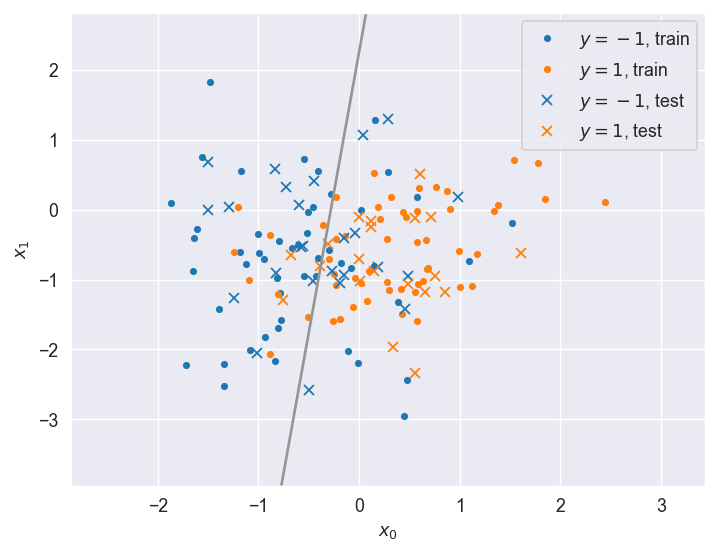

In [10]:
plot_results(X_train[:,1:], y_train, X_test[:,1:], y_test, score_fn=lambda x: np.dot(x,w_adagrad[1:])+w_adagrad[0])

Plot the decision boundary for the Momentum algorithm.

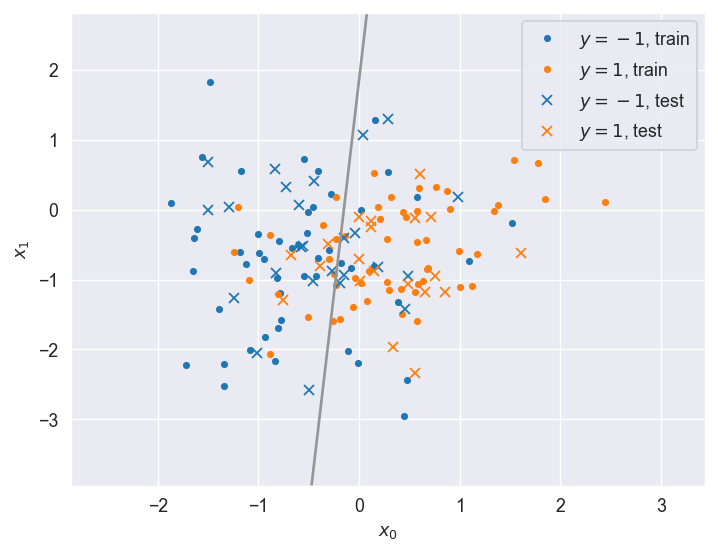

In [11]:
plot_results(X_train[:,1:], y_train, X_test[:,1:], y_test, score_fn=lambda x: np.dot(x,w_momentum[1:])+w_momentum[0])

### 6. Use optimizer in PyTorch

In practice, we rarely implement optimization algorithms from scratch. Instead, we use the built-in optimizers in PyTorch. The `torch.optim` package provides several optimization algorithms. To use the AdaGrad and Momentum algorithms, we can use the `Adagrad` and `SGD` classes in the `torch.optim` package, respectively. 

In the following code, we will reconstruct the dataset with the standard `0`/`1` encoding for binary class labels and `20` features (extra `18` redundant features) and use a multi-layer perceptron (MLP) to classify the data (MLP is not a linear classifier). We use cross-entropy loss as the loss function and set the batch size to `10` for training. The following code provides a very commom pipeline for training a neural network for classification tasks in PyTorch.

You can change the optimizer by change the parameter `optimizer`. Play with the parameters of the optimizers and see how the performance of the model changes. A full description of the parameters of the optimizers can be found [here](https://pytorch.org/docs/stable/optim.html).

In [12]:
import torch.nn as nn

def train_perceptron_pytorch(X_train, X_test, y_train, y_test, n_epochs=30, eta=0.1, optimizer='SGD'):
    X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)
    
    # Create iterable dataset in Torch format
    train_ds = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=10)
    test_ds = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=10)
    
    # Create the multi-layer perceptron model
    model = nn.Sequential(
            nn.Linear(21, 2, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(2, 2, dtype=torch.float64),
            )
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Setup the optimizer. This implements the basic gradient descent update
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=eta)
    elif optimizer == 'Momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.5)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=eta, eps=1e-10)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    else:
        raise ValueError('Invalid optimizer')
    
    for epoch in range(n_epochs):
        for i, (xi, yi) in enumerate(train_loader):
            #Compute loss F(w)
            yi = yi.long()
            logits = model(xi)
            loss = criterion(logits, yi)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, yi).float()).item()
            
            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next ieration
        
        # Evaluate the model, not necessary for training
        if epoch % 4 == 0:
            print("Epoch {}/{}: mean loss = {}, train acc = {}".format(epoch, n_epochs, loss.item(), train_acc))
            with torch.no_grad():
                for xi, yi in test_loader:
                    yi = yi.long()
                    logits = model(xi)
                    loss = criterion(logits, yi)
                    predictions = torch.argmax(logits, dim=1)
                    test_acc = torch.mean(torch.eq(predictions, yi).float()).item()
                print("Test acc = {}".format(test_acc))

In [13]:
X, y = make_classification(n_samples=200, n_features=20, n_informative=2, 
                           n_redundant=18, n_clusters_per_class=1, flip_y=0,
                           class_sep=0.1, random_state=12)
X = np.hstack([np.ones((X.shape[0], 1)), X]) # add bias term
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90051)

train_perceptron_pytorch(X_train, X_test, y_train, y_test, n_epochs=20, optimizer='Adagrad')

Epoch 0/20: mean loss = 0.709158947221999, train acc = 0.30000001192092896
Test acc = 0.4000000059604645
Epoch 4/20: mean loss = 0.7371281518172627, train acc = 0.20000000298023224
Test acc = 0.800000011920929
Epoch 8/20: mean loss = 0.7360119081768257, train acc = 0.4000000059604645
Test acc = 0.800000011920929
Epoch 12/20: mean loss = 0.7314727530579656, train acc = 0.4000000059604645
Test acc = 0.800000011920929
Epoch 16/20: mean loss = 0.7194078013786596, train acc = 0.4000000059604645
Test acc = 0.699999988079071


### 7. Autoencoder

Recall from lectures that an autoencoder is used to learn an 'efficient' or lower dimensional coding of the input $\mathbf{x} \in \mathbb{R}^n$ to some latent code $\mathbf{z} \in \mathbb{R}^d$. The intuitive idea is that we wish to recover the high-dimensional, potentially sparse data signal represented by $\mathbf{x}$ from some low-dimensional projection $\mathbf{z}$. By enforcing a lower-dimensional projection, we would like our representation to discard redundant dimensions while retaining dimensions which correspond to intrinsic aspects of the input space. Autoencoding-based models have many applications such as image/speech synthesis, super-resolution and compressed-sensing. 

The autoencoder is trained in an unsupervised manner. It is composed of two components:
* The _encoder_ $f$ from the original space to the latent space, $f(\mathbf{x}) = \mathbf{z}$
* The _decoder_ $g$ from the latent space to the original space, $g(\mathbf{z}) = \mathbf{\hat{x}}$

The autoencoder parameters are learnt such that $g \circ f$ is close to the identity when averaged over the training set. As the latent space is typically much lower dimensional than the original space, the encoder needs to learn a compact representation of the original data that contains sufficient information for the decoder to reconstruct.


The simplest autoencoder model occurs when both the encoder and decoder are linear functions. It is well known (Bourlard and Kamp 1988) that for a linear autoencoder with encoder and decoder functions represented by matrices:
* $Y \in \mathbb{R}^{d \times n}$
* $Y' \in \mathbb{R}^{n \times d}$

respectively, then the quadratic error objective 

$$ \min_{Y, Y'} \sum_k \Vert \mathbf{x}_k - YY'\mathbf{x}_k \Vert^2 $$
is minimized by the PCA decomposition (as you'll see in week 9).

For more general mappings we minimize an empirical estimate of the expected quadratic loss:

$$ \min_{f,g} \sum_k \Vert \mathbf{x}_k - g \circ f(\mathbf{x}_k) \Vert^2 $$

We will use a simple MLP for the encoder and a decoder composed of nn.Linear layers:

Encoder:
* Linear layer with `n_features` input features and `n_hidden` output features

Decoder:
* Linear layer with `n_hidden` input features and `n_features` output features

In [14]:
from itertools import chain

def autoencoder(X_train, X_test, y_train, y_test, n_features=21, n_hidden=10, n_epochs=30):
    X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)
    
    # Create iterable dataset in Torch format
    train_ds = torch.utils.data.TensorDataset(X_train, X_train)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=10)
    test_ds = torch.utils.data.TensorDataset(X_test, X_test)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=10)
    
    # Create the encoder and decoder
    encoder = nn.Linear(n_features, n_hidden, dtype=torch.float64)
    decoder = nn.Linear(n_hidden, n_features, dtype=torch.float64)

    # Define the loss function
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=1e-3)

    # Track the loss
    running_loss = list()

    # Train the autoencoder
    for epoch in range(n_epochs):
        epoch_loss = 0.
        for i, (x, _) in enumerate(train_loader):
            batch_size = x.shape[0]

            code = encoder(x)
            reconstructed_x = decoder(code)

            loss = criterion(input=reconstructed_x, target=x) / batch_size

            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next iteration


            # ============================================================================
            # You can safely ignore the boilerplate code below - just reports metrics over
            # training and test sets

            running_loss.append(loss.item())

            epoch_loss += loss.item()

            if i % 4 == 0:  # Log training stats
                mean_loss = epoch_loss / (i+1)
                print('[TRAIN] Epoch {} [{}/{}]| Mean loss {:.4f}'.format(epoch, 
                    i, len(train_loader), mean_loss))

        print('Epoch complete! Mean training loss: {:.4f}'.format(epoch_loss/len(train_loader)))

        test_loss = 0.
        
        for i, data in enumerate(test_loader):
            x, _ = data
            
            with torch.no_grad():
                code = encoder(x)
                reconstructed_x = decoder(code)

                test_loss += criterion(input=reconstructed_x, target=x).item() / batch_size

        print('[TEST] Mean loss {:.4f}'.format(test_loss/len(test_loader)))

    return encoder, decoder
            

In [15]:
encoder, decoder = autoencoder(X_train, X_test, y_train, y_test, n_features=21, n_hidden=10, n_epochs=30)

[TRAIN] Epoch 0 [0/14]| Mean loss 0.0290
[TRAIN] Epoch 0 [4/14]| Mean loss 0.0370
[TRAIN] Epoch 0 [8/14]| Mean loss 0.0429
[TRAIN] Epoch 0 [12/14]| Mean loss 0.0444
Epoch complete! Mean training loss: 0.0433
[TEST] Mean loss 0.0368
[TRAIN] Epoch 1 [0/14]| Mean loss 0.0252
[TRAIN] Epoch 1 [4/14]| Mean loss 0.0320
[TRAIN] Epoch 1 [8/14]| Mean loss 0.0373
[TRAIN] Epoch 1 [12/14]| Mean loss 0.0386
Epoch complete! Mean training loss: 0.0376
[TEST] Mean loss 0.0318
[TRAIN] Epoch 2 [0/14]| Mean loss 0.0223
[TRAIN] Epoch 2 [4/14]| Mean loss 0.0280
[TRAIN] Epoch 2 [8/14]| Mean loss 0.0328
[TRAIN] Epoch 2 [12/14]| Mean loss 0.0337
Epoch complete! Mean training loss: 0.0329
[TEST] Mean loss 0.0274
[TRAIN] Epoch 3 [0/14]| Mean loss 0.0196
[TRAIN] Epoch 3 [4/14]| Mean loss 0.0245
[TRAIN] Epoch 3 [8/14]| Mean loss 0.0287
[TRAIN] Epoch 3 [12/14]| Mean loss 0.0292
Epoch complete! Mean training loss: 0.0285
[TEST] Mean loss 0.0230
[TRAIN] Epoch 4 [0/14]| Mean loss 0.0170
[TRAIN] Epoch 4 [4/14]| Mean lo

Now, the input data with `21` features can be effectively compressed to `10` features with the **encoder**. Let use the compressed hidden representation to predict the label! We will re-use the code from the function `train_perceptron_pytorch` with little modification.

In [16]:
def train_perceptron_pytorch_with_compressed_data(X_train, X_test, y_train, y_test, encoder, n_epochs=30, eta=0.1, optimizer='SGD'):
    X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)
    
    # Create iterable dataset in Torch format
    train_ds = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=10)
    test_ds = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=10)

    # Create the multi-layer perceptron model
    model = nn.Sequential(
            nn.Linear(10, 2, dtype=torch.float64), # Note that the input size is now 10
            nn.ReLU(),
            nn.Linear(2, 2, dtype=torch.float64),
            )
    
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Setup the optimizer. This implements the basic gradient descent update
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=eta)
    elif optimizer == 'Momentum':
        optimizer = torch.optim.SGD(model.parameters(), lr=eta, momentum=0.5)
    elif optimizer == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=eta, eps=1e-10)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    else:
        raise ValueError('Invalid optimizer')
    
    for epoch in range(n_epochs):
        for i, (x, y) in enumerate(train_loader):
            #Compute loss F(w)
            y = y.long()
            code = encoder(x) # Note we compress the input here. 
            logits = model(code)
            loss = criterion(logits, y)

            predictions = torch.argmax(logits, dim=1)
            train_acc = torch.mean(torch.eq(predictions, y).float()).item()
            
            loss.backward()               # Backward pass (compute parameter gradients)
            optimizer.step()              # Update weight parameter using SGD
            optimizer.zero_grad()         # Reset gradients to zero for next ieration
        
        # Evaluate the model, not necessary for training
        if epoch % 4 == 0:
            print("Epoch {}/{}: mean loss = {}, train acc = {}".format(epoch, n_epochs, loss.item(), train_acc))
            with torch.no_grad():
                for x, y in test_loader:
                    y = y.long()
                    code = encoder(x) # Note we compress the input here.
                    logits = model(code)
                    loss = criterion(logits, y)
                    predictions = torch.argmax(logits, dim=1)
                    test_acc = torch.mean(torch.eq(predictions, y).float()).item()
                print("Test acc = {}".format(test_acc))

train_perceptron_pytorch_with_compressed_data(X_train, X_test, y_train, y_test, encoder, n_epochs=20, optimizer='Adagrad')

Epoch 0/20: mean loss = 0.549135385127963, train acc = 0.699999988079071
Test acc = 0.800000011920929
Epoch 4/20: mean loss = 0.45005583333307764, train acc = 0.800000011920929
Test acc = 0.699999988079071
Epoch 8/20: mean loss = 0.4300556662769088, train acc = 0.800000011920929
Test acc = 0.699999988079071
Epoch 12/20: mean loss = 0.4197225975811393, train acc = 0.800000011920929
Test acc = 0.699999988079071
Epoch 16/20: mean loss = 0.4112328705536278, train acc = 0.800000011920929
Test acc = 0.699999988079071


## Bonus task (optional)
***
The combination of AdaGrad and Momentum is called **Adam**. It is a popular optimization algorithm in deep learning. It combines the advantages of both AdaGrad and Momentum. The update rule for the model parameters $\mathbf{w}$ is given by:
$$
\begin{align*}
\mathbf{w}^{i+1} &= \mathbf{w}^{i} - \frac{\eta}{\sqrt{\hat{v}^{i} / (1-\beta_2)} + \epsilon} \cdot \hat{m}^{i} / \left(1 - \beta_1^i\right)
\end{align*}
$$
where $\hat{m}^{i}$ and $\hat{v}^{i}$ are the first and second moment estimates of the gradients, respectively. The first moment estimate is the exponentially decaying average of past gradients, and the second moment estimate is the exponentially decaying average of past squared gradients. The update rule for the first and second moment estimates are given by:
$$
\begin{align*}
\hat{m}^{i} &= \beta_1 \cdot \hat{m}^{i-1} + (1 - \beta_1) \cdot g^{i} \\
\hat{v}^{i} &= \beta_2 \cdot \hat{v}^{i-1} + (1 - \beta_2) \cdot (g^{i})^2
\end{align*}
$$
where $\beta_1$ and $\beta_2$ are the decay rates of the first and second moment estimates, respectively. The default values of $\beta_1$ and $\beta_2$ are $0.9$ and $0.999$, respectively. The update rule for the model parameters $\mathbf{w}$ is similar to the update rule for the Momentum algorithm, but the learning rate is scaled by the square root of the second moment estimate.

Implement the Adam algorithm for the perceptron model. Remember to reconstruct the dataset as what we did before the Pytorch section.